In [1]:
import pandas as pd
import numpy as np
import os

import sklearn.metrics as metrics

from sklearn import svm

from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score, recall_score, \
    accuracy_score, precision_score, r2_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel

import matplotlib.pyplot as plt

import sklearn
print(sklearn.__version__)

0.23.1


In [3]:
df_sample = pd.read_csv("data/sample.csv")

df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")


In [6]:
def gen_feats_dict(df_train):
    fv = df_train['Sequence'].values
    

    fv_1plex_list = []
    for i in range(len(fv)):
        for j in range(0,4):
            fv_1plex_list.append(fv[i][j:j+1])
    feats1 = list(set(fv_1plex_list))
    #print(i)
    #print(j)
    #print(len(feats1))
    
    feats_dict = {}
    
    feats_dict['1plex_pos0']=feats1
    feats_dict['1plex_pos1']=feats1
    feats_dict['1plex_pos2']=feats1
    feats_dict['1plex_pos3']=feats1
        
    return(feats_dict)


In [7]:
def gen_occ(df,feats_dict):
    
    fv = df['Sequence'].values
    
    occ = {}
    
    fv_1plex_list = []
    for i in range(len(fv)):
        for j in range(0,4):
            fv_1plex_list.append(fv[i][j:j+1])
    #1-plex
    for i in range(len(feats_dict['1plex'])):
        feat = feats_dict['1plex'][i]
        count = fv_1plex_list.count(feat)
        occ[feat] = count
        print("%s: %d"%(feat,count))
    
    return(occ)

In [8]:
def gen_X(df,feats_dict):
    n = df.shape[0]
    d = 0
    for feat_type in list(feats_dict):
        d+=len(feats_dict[feat_type])
    X = np.zeros((n,d))
    print(np.shape(X))
    
    seqs = df["Sequence"].values
    i=0
    for feat_type in list(feats_dict):
        pos = int(feat_type[-1])
        plex = int(feat_type[0])
        for j in range(len(feats_dict[feat_type])):

            for k in range(len(seqs)):
                if feats_dict[feat_type][j] == seqs[k][pos:pos+plex]:
                    X[k][i] = 1

            if i%10==0:
                print(i)
            i+=1

    return(X)
    

In [9]:
feats_dict = gen_feats_dict(df_train)


111999
3
20


In [10]:
X_train_raw = gen_X(df_train,feats_dict)
X_test_raw = gen_X(df_test,feats_dict)

(112000, 80)
0
10
20
30
40
50
60
70
(48000, 80)
0
10
20
30
40
50
60
70


In [12]:


holdout=False
feat_sel1=False
feat_sel2=False

if holdout:
    #make hold out
    X_train,X_hold,y_train,y_hold = train_test_split(
        X_train_raw,y_train,test_size=0.2,random_state=42)

    print(np.shape(X_train))
    print(np.shape(X_hold))
    print(np.sum(y_train))
    print(np.sum(y_hold))
    print("\n")
else:
    X_train = X_train_raw.copy()
    
X_test = X_test_raw.copy()
    
y_train = df_train['Active'].values
n = float(np.shape(y_train)[0])    

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

if feat_sel1:
    lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train, y_train)
    model = SelectFromModel(lsvc, prefit=True)
    X_train = model.transform(X_train)
    X_test = model.transform(X_test)
    
if feat_sel2:
    #feature selection by conditional probability threshold
    a = np.sum(X_train,axis=0)
    b = np.sum(np.transpose(X_train)*y_train,axis=1)
    print(np.shape(a))
    print(np.shape(b))
    c = b/a
    d = np.argwhere(c>0.2).flatten()
    
    X_train = X_train[:,d]
    X_test = X_test[:,d]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
    







(112000, 80)
(112000,)
(48000, 80)
(112000, 80)
(112000,)
(48000, 80)


In [20]:

hp_x = np.array([0.56])
hp_metrics = [
           'test_accuracy',
           'test_recall',
           'test_precision'
          ]
hp_y = np.zeros((hp_x.shape[0],len(hp_metrics)))

for j in range(0,hp_x.shape[0]):
    
    clf_init = HistGradientBoostingClassifier(
        learning_rate = hp_x[j],
        max_iter=200,
        max_leaf_nodes=127,
        min_samples_leaf=20,
        l2_regularization=3.2,
        verbose=10,
        random_state=42)
    
    clf = clf_init.fit(X_train,y_train)
    score = clf.score(X_train,y_train)

    cv_results = cross_validate(clf,X_train,y_train,cv=5,
            scoring=["roc_auc","accuracy","recall","precision"])

    print("train score= %f"%score)
    print("cv roc auc= %f"%np.mean(cv_results['test_roc_auc']))
    print("cv acc= %f"%np.mean(cv_results['test_accuracy']))
    hp_y[j][0] = np.mean(cv_results['test_accuracy'])
    
    print("cv rec= %f"%np.mean(cv_results['test_recall']))
    hp_y[j][1] = np.mean(cv_results['test_recall'])
    
    print("cv prec= %f"%np.mean(cv_results['test_precision']))
    hp_y[j][2] = np.mean(cv_results['test_precision'])

    #print(sigmoid(clf.decision_function(X_train)))
    #p_train=clf.predict(X_train)

    print("y train:")
    print("n pos %f"%np.sum(y_train))
    print("frac pos %f"%(np.sum(y_train)/n))

    print("y train pred:")
    y_train_pred=clf.predict(X_train)
    print("n pos %f"%np.sum(y_train_pred))
    print("frac pos %f"%(np.sum(y_train_pred)/n) ) 

    #p_train=clf.predict_proba(X_train)
    #print("prob sum 0 %f"%np.sum(p_train[:,0]))
    #print("prob sum 1 %f"%np.sum(p_train[:,1]))

    #print(p_train)

    #print("y test:")
    #p_test=clf.predict_proba(X_test)
    #print("prob sum 0 %f"%np.sum(p_test[:,0]))
    #print("prob sum 1 %f"%np.sum(p_test[:,1]))

    if holdout:
        #print("holdout metrics:")
        #holdout_auc = roc_auc_score(y_hold,clf.predict_proba(X_hold)[:,1])
        #print("holdout roc auc= %f"%holdout_auc)
        #holdout_aucs[i] = holdout_auc

        y_hold_pred = clf.predict(X_hold)
        holdout_acc = accuracy_score(y_hold,y_hold_pred)
        print("holdout acc= %f"%holdout_acc)
        holdout_rec = recall_score(y_hold,y_hold_pred)
        print("holdout rec= %f"%holdout_rec)
        holdout_prec = precision_score(y_hold,y_hold_pred)
        print("holdout prec= %f"%holdout_prec)

Binning 0.065 GB of training data: 0.356 s
Binning 0.007 GB of validation data: 0.010 s
Fitting gradient boosted rounds:
[1/200] 1 tree, 75 leaves, max depth = 17, train loss: 0.10573, val loss: 0.11347, in 0.082s
[2/200] 1 tree, 124 leaves, max depth = 23, train loss: 0.07860, val loss: 0.08241, in 0.170s
[3/200] 1 tree, 127 leaves, max depth = 36, train loss: 0.05738, val loss: 0.06261, in 0.178s
[4/200] 1 tree, 127 leaves, max depth = 37, train loss: 0.04672, val loss: 0.05207, in 0.132s
[5/200] 1 tree, 127 leaves, max depth = 49, train loss: 0.03853, val loss: 0.04384, in 0.212s
[6/200] 1 tree, 127 leaves, max depth = 31, train loss: 0.03437, val loss: 0.03967, in 0.112s
[7/200] 1 tree, 127 leaves, max depth = 28, train loss: 0.03200, val loss: 0.03783, in 0.115s
[8/200] 1 tree, 127 leaves, max depth = 27, train loss: 0.02909, val loss: 0.03518, in 0.109s
[9/200] 1 tree, 127 leaves, max depth = 41, train loss: 0.02709, val loss: 0.03374, in 0.169s
[10/200] 1 tree, 127 leaves, max d

[86/200] 1 tree, 127 leaves, max depth = 38, train loss: 0.00413, val loss: 0.01943, in 0.112s
[87/200] 1 tree, 127 leaves, max depth = 29, train loss: 0.00407, val loss: 0.01947, in 0.098s
[88/200] 1 tree, 127 leaves, max depth = 45, train loss: 0.00401, val loss: 0.01947, in 0.097s
[89/200] 1 tree, 127 leaves, max depth = 28, train loss: 0.00394, val loss: 0.01943, in 0.098s
[90/200] 1 tree, 127 leaves, max depth = 38, train loss: 0.00389, val loss: 0.01943, in 0.132s
[91/200] 1 tree, 127 leaves, max depth = 27, train loss: 0.00383, val loss: 0.01945, in 0.087s
[92/200] 1 tree, 127 leaves, max depth = 36, train loss: 0.00378, val loss: 0.01945, in 0.099s
[93/200] 1 tree, 127 leaves, max depth = 36, train loss: 0.00373, val loss: 0.01944, in 0.099s
[94/200] 1 tree, 127 leaves, max depth = 29, train loss: 0.00367, val loss: 0.01952, in 0.091s
[95/200] 1 tree, 127 leaves, max depth = 39, train loss: 0.00362, val loss: 0.01950, in 0.134s
[96/200] 1 tree, 127 leaves, max depth = 26, train

[4/200] 1 tree, 127 leaves, max depth = 38, train loss: 0.04619, val loss: 0.05092, in 0.081s
[5/200] 1 tree, 127 leaves, max depth = 34, train loss: 0.03905, val loss: 0.04377, in 0.081s
[6/200] 1 tree, 127 leaves, max depth = 25, train loss: 0.03589, val loss: 0.04165, in 0.109s
[7/200] 1 tree, 127 leaves, max depth = 38, train loss: 0.03223, val loss: 0.03894, in 0.081s
[8/200] 1 tree, 127 leaves, max depth = 36, train loss: 0.02942, val loss: 0.03633, in 0.087s
[9/200] 1 tree, 127 leaves, max depth = 42, train loss: 0.02736, val loss: 0.03469, in 0.108s
[10/200] 1 tree, 127 leaves, max depth = 50, train loss: 0.02554, val loss: 0.03374, in 0.089s
[11/200] 1 tree, 127 leaves, max depth = 25, train loss: 0.02405, val loss: 0.03243, in 0.105s
[12/200] 1 tree, 127 leaves, max depth = 36, train loss: 0.02285, val loss: 0.03159, in 0.082s
[13/200] 1 tree, 127 leaves, max depth = 34, train loss: 0.02184, val loss: 0.03151, in 0.087s
[14/200] 1 tree, 127 leaves, max depth = 28, train loss:

[23/200] 1 tree, 127 leaves, max depth = 38, train loss: 0.01385, val loss: 0.02537, in 0.125s
[24/200] 1 tree, 127 leaves, max depth = 40, train loss: 0.01335, val loss: 0.02543, in 0.081s
[25/200] 1 tree, 127 leaves, max depth = 34, train loss: 0.01289, val loss: 0.02541, in 0.088s
[26/200] 1 tree, 127 leaves, max depth = 24, train loss: 0.01253, val loss: 0.02540, in 0.085s
[27/200] 1 tree, 127 leaves, max depth = 38, train loss: 0.01220, val loss: 0.02545, in 0.084s
[28/200] 1 tree, 127 leaves, max depth = 28, train loss: 0.01183, val loss: 0.02528, in 0.122s
[29/200] 1 tree, 127 leaves, max depth = 32, train loss: 0.01147, val loss: 0.02501, in 0.091s
[30/200] 1 tree, 127 leaves, max depth = 29, train loss: 0.01120, val loss: 0.02502, in 0.096s
[31/200] 1 tree, 127 leaves, max depth = 25, train loss: 0.01089, val loss: 0.02498, in 0.092s
[32/200] 1 tree, 127 leaves, max depth = 37, train loss: 0.01060, val loss: 0.02492, in 0.280s
[33/200] 1 tree, 127 leaves, max depth = 29, train

[26/200] 1 tree, 127 leaves, max depth = 27, train loss: 0.01295, val loss: 0.02469, in 0.111s
[27/200] 1 tree, 127 leaves, max depth = 35, train loss: 0.01257, val loss: 0.02437, in 0.119s
[28/200] 1 tree, 127 leaves, max depth = 31, train loss: 0.01216, val loss: 0.02451, in 0.130s
[29/200] 1 tree, 127 leaves, max depth = 41, train loss: 0.01178, val loss: 0.02410, in 0.166s
[30/200] 1 tree, 127 leaves, max depth = 29, train loss: 0.01144, val loss: 0.02403, in 0.112s
[31/200] 1 tree, 127 leaves, max depth = 34, train loss: 0.01108, val loss: 0.02379, in 0.133s
[32/200] 1 tree, 127 leaves, max depth = 38, train loss: 0.01076, val loss: 0.02361, in 0.111s
[33/200] 1 tree, 127 leaves, max depth = 32, train loss: 0.01047, val loss: 0.02345, in 0.107s
[34/200] 1 tree, 127 leaves, max depth = 35, train loss: 0.01018, val loss: 0.02330, in 0.119s
[35/200] 1 tree, 127 leaves, max depth = 43, train loss: 0.00988, val loss: 0.02328, in 0.086s
[36/200] 1 tree, 127 leaves, max depth = 31, train

[20/200] 1 tree, 127 leaves, max depth = 40, train loss: 0.01592, val loss: 0.02713, in 0.096s
[21/200] 1 tree, 127 leaves, max depth = 24, train loss: 0.01542, val loss: 0.02705, in 0.099s
[22/200] 1 tree, 127 leaves, max depth = 36, train loss: 0.01479, val loss: 0.02669, in 0.140s
[23/200] 1 tree, 127 leaves, max depth = 28, train loss: 0.01432, val loss: 0.02638, in 0.101s
[24/200] 1 tree, 127 leaves, max depth = 46, train loss: 0.01374, val loss: 0.02596, in 0.103s
[25/200] 1 tree, 127 leaves, max depth = 36, train loss: 0.01334, val loss: 0.02554, in 0.129s
[26/200] 1 tree, 127 leaves, max depth = 25, train loss: 0.01291, val loss: 0.02528, in 0.142s
[27/200] 1 tree, 127 leaves, max depth = 30, train loss: 0.01255, val loss: 0.02522, in 0.088s
[28/200] 1 tree, 127 leaves, max depth = 29, train loss: 0.01221, val loss: 0.02519, in 0.105s
[29/200] 1 tree, 127 leaves, max depth = 28, train loss: 0.01184, val loss: 0.02481, in 0.101s
[30/200] 1 tree, 127 leaves, max depth = 38, train

In [21]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(112000, 80)
(112000,)
(48000, 80)


In [22]:
p_train=clf.predict_proba(X_train)
print("prob sum 0 %f"%np.sum(p_train[:,0]))
print("prob sum 1 %f"%np.sum(p_train[:,1]))

prob sum 0 107806.647868
prob sum 1 4193.352132


In [23]:
print(n/(2*np.bincount(y_train)))


[ 0.51954317 13.29219084]


In [24]:


print("y test pred:")
y_test_pred=clf.predict(X_test)
print("n pos %f"%np.sum(y_test_pred))
print("frac pos %f"%(np.sum(y_test_pred)/n) )

y test pred:
n pos 1715.000000
frac pos 0.015312


In [25]:
print(y_test_pred)

array([0, 0, 0, ..., 0, 0, 0])

In [26]:
result_str = ""
for i in range(len(y_test_pred)):
    result_str+=str(y_test_pred[i])
    result_str+="\n"

submission = open("sub2.csv","w")
submission.write(result_str)
submission.close()

In [27]:
#HIST GBDT l2, stepsize experiment, 200 trees/iter

print(hp_x)
print(hp_y)

[0.56]
[[0.99191964 0.86161994 0.91857162]]


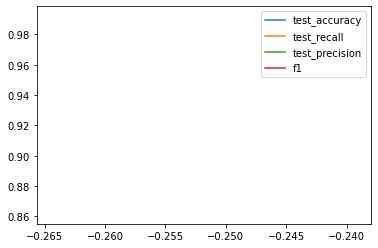

In [28]:
f1 = plt.figure()
ax1 = f1.add_subplot(111)
for k in range(0,len(hp_metrics)):
    ax1.plot(np.log10(hp_x),hp_y[:,k],label=hp_metrics[k])
    
f1 = 2*hp_y[:,1]*hp_y[:,2]/(hp_y[:,1]+hp_y[:,2])
ax1.plot(np.log10(hp_x),f1,label="f1")
    
ax1.legend()
plt.show()